In [ ]:
# compute conservation across each genome for every position on the reference genome

In [2]:
import os
import re
import sys
import csv
import time
import shutil
import random
import sqlite3
import requests
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO

In [3]:
base_dir = Path.cwd().parent.parent
data_dir = base_dir / 'HIV_Atlas_Creation/data'

reference_data = {
    11676: {"accid": "K03455.1",
            "organism": "HIV-1",
            "fasta": data_dir / "reference/K03455.1.fasta",
            "gtf": data_dir / "reference/K03455.1.gtf",
            "description": 'Human immunodeficiency virus type 1 (HXB2), complete genome; HIV1/HTLV-III/LAV reference genome'},
    11723: {"accid": "M33262.1",
            "organism": "SIV",
            "fasta": data_dir / "reference/M33262.1.fasta",
            "gtf": data_dir / "reference/M33262.1.gtf",
            "description": 'Simian (macaque) immunodeficiency virus, isolate 239, complete proviral genome.'}
}
reference_ids = set([x["accid"] for x in reference_data.values()])

sequence_dir = data_dir / 'sequences'
assert sequence_dir.exists(), f"sequence_dir does not exist: {sequence_dir}"

annotation_dir = data_dir / 'annotation'
assert annotation_dir.exists(), f"annotation_dir does not exist: {annotation_dir}"

outdir = data_dir / 'conservation'
outdir.mkdir(exist_ok=True)

accession_list_fname = data_dir / 'complete_sequences.2022.accessions'
summary_file =data_dir / "download.summary.tsv"

annotation_log_fname = data_dir / 'annotation/log.txt'
# load the annotation log file to extract relevant data into the database tsv
log_df = pd.read_csv(annotation_log_fname)

complete_log_df = log_df[log_df["status"] == "complete"].reset_index(drop=True)
complete_log_df.head()

,accid,organism,status,genome_score,junction_score,transcript_score,miniprot_score,guide_score
0,MH705157.1,HIV-1,complete,0.871767,0.944444,0.799090,0.661600,0.559152
1,DQ396400.1,HIV-1,complete,0.901976,0.958333,0.845619,0.661978,0.720496
2,KU168256.1,HIV-1,complete,0.878658,0.937500,0.819815,0.559410,0.719850
3,MH705158.1,HIV-1,complete,0.874285,0.958333,0.790237,0.407212,0.753737
4,MH705151.1,HIV-1,complete,0.823610,0.914352,0.732868,0.391839,0.564241


In [4]:
# software links
soft_dir = base_dir / 'soft'
mafft_bin = "mafft"

In [5]:
# generated files
qry_fasta_fname = outdir / 'all_sequences.fasta'
msa_fname = outdir / 'all_sequences.msa'
bed_fname = outdir / 'K03455.1.conservation.simple.all.bed'

In [17]:
# load list of genomes

# read summary tsv line by line using csv module
genomes = {}
with open(summary_file,"r") as inFP:
    reader = csv.reader(inFP, delimiter="\t")
    # skip header
    next(reader)
    for lno, (accid, is_ref_genome, organism, taxid, fasta, gff, is_valid, ref_start, ref_end) in enumerate(reader):
        if accid in reference_ids:
            continue

        if (annotation_dir / accid / f"{accid}.vira.gtf").exists():
            genome_fasta_fname = sequence_dir / f"{accid}.fasta"
            
            # load line from the annotation log to get the score
            if len(log_df[log_df["accid"]==accid]) == 0:
                print(f"Warning: {accid} not found in log file, skipping")
                continue
            
            log_row = log_df[log_df["accid"]==accid]
            assert len(log_row) == 1, f"Error: multiple rows found for {accid}"

            status = log_row["status"].values[0]
            if not status == "complete":
                print(f"Warning: {accid} is not complete, skipping")
                continue
            
            if not int(taxid) == 11676:
                continue
            
            acc_outdir = annotation_dir / accid
            acc_outdir.mkdir(exist_ok=True)
            genome_fasta_fname = sequence_dir / f"{accid}.fasta"
            genome_gtf_fname = acc_outdir / f"{accid}.vira.gtf"
            
            genomes[accid] = (genome_fasta_fname, genome_gtf_fname)

In [19]:
# build a file of all sequence for alignments
with open(qry_fasta_fname, 'w') as outFP:
    for accid, (genome_fasta_fname, genome_gtf_fname) in genomes.items():
        with open(genome_fasta_fname, 'r') as inFP:
            for line in inFP:
                outFP.write(line)

In [ ]:
# run mafft
# mafft --6merpair --addfragments othersequences referencesequence > output
cmd = [mafft_bin, '--6merpair', '--addfragments', str(qry_fasta_fname), str(reference_data[11676]["fasta"])]
print(" ".join(cmd) + " > " + str(msa_fname))
with open(msa_fname, 'w') as f:
    subprocess.run(cmd, stdout=f)

In [21]:
# load a matrix from the msa where columns are positions on the reference genome
# rows are genomes
# and values are tuple of (genome position, nucleotide) at that position

def load_msa_as_matrix(fasta_file):
    # Load the alignment
    sequences = list(SeqIO.parse(fasta_file, "fasta"))
    alignment_length = len(sequences[0].seq)
    for seq_record in sequences:
        if len(seq_record.seq) != alignment_length:
            raise ValueError("All sequences in the alignment must be the same length.")

    # Create a matrix where each row corresponds to a genome
    matrix = []
    idx = {} # map of accession to row in matrix
    for seq_index, seq_record in enumerate(sequences):
        idx[seq_record.id] = seq_index
        row = []
        genome_position = 0  # Tracks the position in the original genome
        for align_position, nucleotide in enumerate(seq_record.seq):
            if nucleotide != "-":  # Skipping gaps
                genome_position += 1
            row.append((genome_position, nucleotide))
        matrix.append(row)

    return matrix, idx

msa_mat, msa_idx = load_msa_as_matrix(msa_fname)


In [ ]:
# now cleanup the matrix by removing all column which do not contain reference genome nucleotide

def cleanup_matrix(mat, ref_idx):
    assert len(mat) > 0, "Matrix must have at least one row."
    assert ref_idx > 0 or ref_idx < len(mat), "Reference index is out of bounds."

    reference_row = mat[ref_idx]
    columns_to_keep = [i for i in range(len(reference_row)) if reference_row[i][1] != '-']

    clean_mat = []
    for row in mat:
        clean_row = [row[i] for i in columns_to_keep]
        clean_mat.append(clean_row)

    return clean_mat


ref_msa_idx = msa_idx[reference_data[11676]["accid"]]
clean_msa_mat = cleanup_matrix(msa_mat, ref_msa_idx)

In [23]:
# compute simple conservation: for each position - count the number of genoems where the nucleotide is the same as the reference genome
def compute_simple_conservation(mat, ref_idx):
    assert len(mat) > 0, "Matrix must have at least one row."
    assert ref_idx > 0 or ref_idx < len(mat), "Reference index is out of bounds."
    ref_row = mat[ref_idx]
    
    conservation_counts = []
    
    # Iterate over each column (position)
    for col_index in range(len(ref_row)):
        ref_nuc = ref_row[col_index][1]
        count = 0
        
        for row in mat:
            if row[col_index][1] == ref_nuc:
                count += 1
                
        conservation_counts.append(count)
    
    return conservation_counts

simple_conservation = compute_simple_conservation(clean_msa_mat, ref_msa_idx)

In [24]:
# write result as bed format
with open(bed_fname, 'w') as outFP:
    for i, count in enumerate(simple_conservation):
        outFP.write(f"{reference_data[11676]['accid']}\t{i}\t{i+1}\t-\t{count}\t+\n")

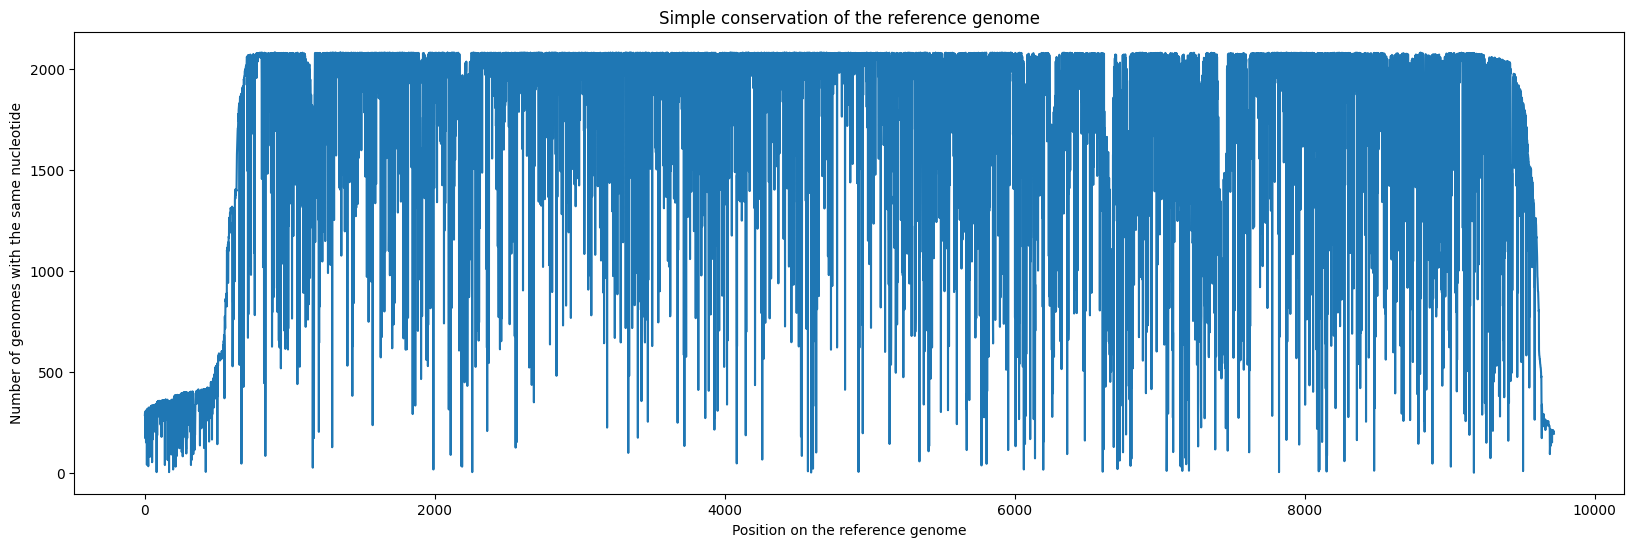

In [25]:
# construct a plotof the conservation using seaborn

# load the conservation data
conservation_scores = []
with open(bed_fname, 'r') as inFP:
    for line in inFP:
        fields = line.strip().split("\t")
        conservation_scores.append(int(fields[4]))

plt.figure(figsize=(20, 6))
sns.lineplot(x=range(len(conservation_scores)), y=conservation_scores)
plt.xlabel("Position on the reference genome")
plt.ylabel("Number of genomes with the same nucleotide")
plt.title("Simple conservation of the reference genome")
plt.show()


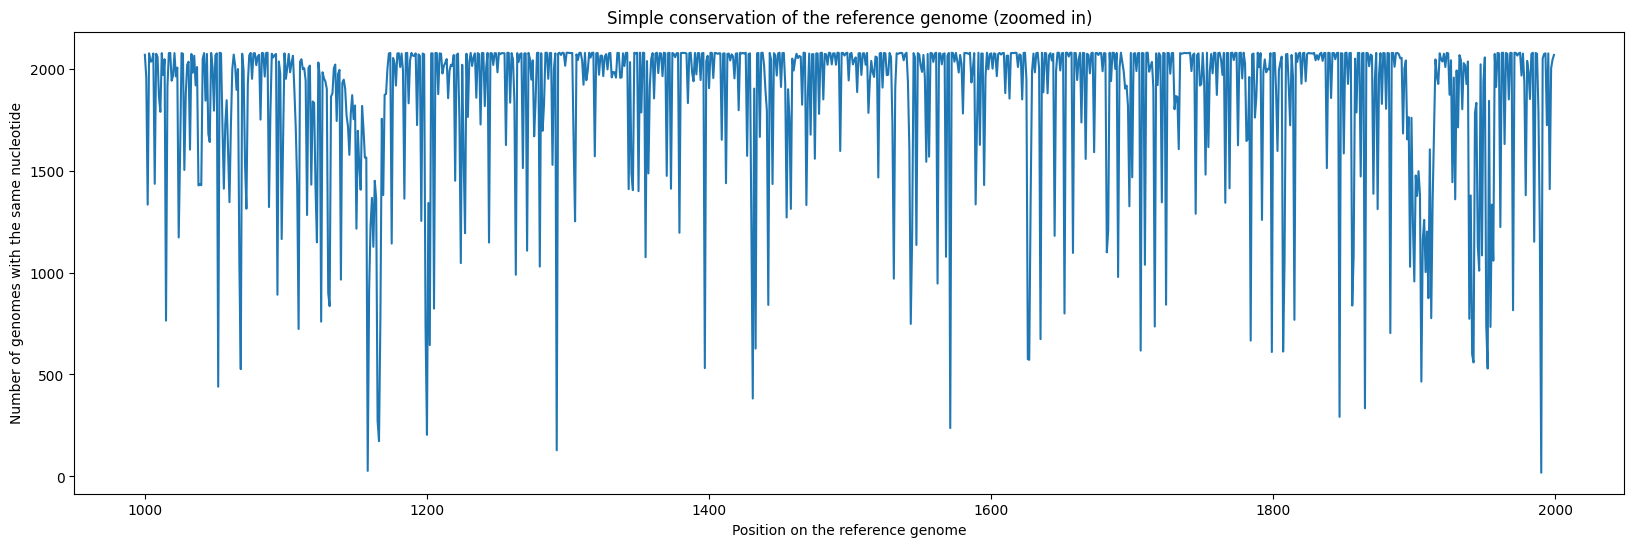

In [26]:
# zoom on a specific position
plt.figure(figsize=(20, 6))
sns.lineplot(x=range(1000, 2000), y=conservation_scores[1000:2000])
plt.xlabel("Position on the reference genome")
plt.ylabel("Number of genomes with the same nucleotide")
plt.title("Simple conservation of the reference genome (zoomed in)")
plt.show()